In [1]:
import networkx as nx
import pulp
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

In [2]:
#Parser de fichiers
df = pd.read_csv("data.txt",header=None)
M = df.values
df.head()

,0,1,2,3
0,0,-11.03,-82.33,46
1,1,-4.93,-98.05,96
2,2,81.52,2.41,49
3,3,36.82,-42.62,71
4,4,-69.86,11.88,27


In [3]:
def plot_points(M, s, color=[]):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1], frameon=False, aspect=1)
    if len(color) == 0:
        scat = ax.scatter(M[:,1], M[:,2],s=s*M[:,3])
    else:
        scat = ax.scatter(M[:,1], M[:,2],s=s*M[:,3], c=color)

In [4]:
def get_sub_section(M, coord1, coord2):
    indices = []
    for i in range(M.shape[0]):
        if M[i,1] >= coord1[0] and M[i,1] <= coord2[0] and M[i, 2] >= coord1[1] and M[i, 2] <= coord2[1]:
            indices.append(i)
    # colors
    colors = np.zeros((M.shape[0]))
    for i in indices:
        colors[i] = 1
    return np.copy(M)[indices,:], colors

In [5]:
M_sub, colors = get_sub_section(M, (-20.,-20.), (20.,20.))
M_sub.shape

(414, 4)

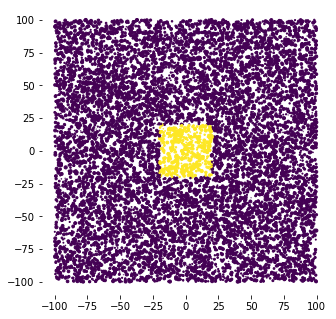

In [6]:
plot_points(M, 0.1, colors)

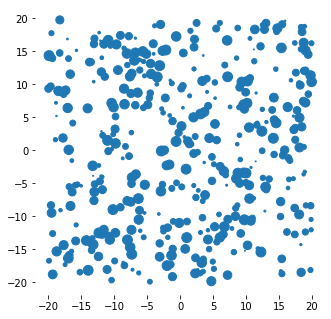

In [7]:
plot_points(M_sub, 1)

In [8]:
#g = nx.to_directed(nx.barabasi_albert_graph(10000, 2))
#nx.draw(g, with_labels=True)
#plt.show()

In [9]:
def create_distance_edges(M, knn=-1):
    max_pair = (-1, -1)
    max_distance = 0
    dim = M.shape[0]
    edges_dist = {}
    edges_list = []
    for i in range(dim):
        temp = np.zeros((dim))
        for j in range(dim):
            temp[j] = math.sqrt((M[i,1] - M[j,1])**2 + (M[i,2] - M[j,2])**2)
        max_ = np.argmax(temp)
        if temp[max_] > max_distance:
            max_distance = temp[max_]
            max_pair = (i,max_)
        
        if knn == -1:
            for j in range(dim):
                if i != j:
                    edges_list.append((i, j))
                    edges_list.append((j, i))
                    edges_dist[i, j] = temp[j]
                    edges_dist[j, i] = temp[j]
        else:
            min_dist = np.argsort(temp)
            for j in range(1,knn+1):
                to = min_dist[j]
                edges_list.append((i, to))
                edges_list.append((to, i))
                edges_dist[i, to] = temp[to]
                edges_dist[to, i] = temp[to]
    return edges_dist, edges_list, max_pair, dim

In [10]:
edges_dist, edges_list, max_pair, dim = create_distance_edges(M_sub, 3)
rewards = M_sub[:,3]
print(dim)

414


In [11]:
_max_time = 10000.

In [12]:
def get_solution_and_add_constraints(G, edge_activation, edge_distances, source, target):
    validated = []
    correct = []
    actual_node = source
    sum_real = 0
    edges_choosen = [[] for i in range(len(G.nodes))]
    for i,j in G.edges:
        if edge_activation[i,j].value() == 1.0:
            edges_choosen[i].append(j)
    while actual_node != target:
        if len(edges_choosen[actual_node]) != 1:
            print(actual_node, edges_choosen[actual_node])
            print("error")
        else:
            correct.append(actual_node)
            next_ = edges_choosen[actual_node][0]
            validated.append((actual_node,next_))
            sum_real += edge_distances[actual_node,next_]
            actual_node = next_
    correct.append(actual_node)
    # detect cycle and will delete one of the edges
    cycles = []
    memory = []
    for i in range(len(edges_choosen)):
        if i not in correct and i not in memory and len(edges_choosen[i]) != 0:
            temp = []
            final_node = i
            temp.append(final_node)
            final_node = edges_choosen[final_node][0]
            while final_node != i:
                next_ = edges_choosen[final_node][0]
                temp.append(final_node)
                final_node = next_
            memory += temp
            cycles.append(temp)
    # select first edge of each cycles and will add it to the future constraint
    return [(cycle[0], cycle[1]) for cycle in cycles], validated, sum_real

In [13]:
def Optimize(edges_dist, edges_list, max_pair, dim, _max_time, rewards):
    # Source and target
    source = max_pair[0]
    target = max_pair[1]
    print("# --------------------------------------------------------- #")
    print(" > Source({}) => Target({}) : Distance = {}".format(source, target,
        math.sqrt((M_sub[max_pair[0],1] - M_sub[max_pair[1],1])**2 + (M_sub[max_pair[0],2] - M_sub[max_pair[1],2])**2)))
    print("# --------------------------------------------------------- #")
    
    update_constraints = []
    loop = True
    iteration = 0
    while iteration==0:
        # Create the Graph
        G = nx.DiGraph()
        # add nodes
        for i in range(dim):
            G.add_node(i)
        # add edges
        G.add_edges_from(edges_list, color='red')
        nx.set_edge_attributes(G, edges_dist, 'weight')
        # Non changing parameters
        edge_distances = nx.get_edge_attributes(G, 'weight')
        
        # instantiate
        prob = pulp.LpProblem("MaxRewardInLimitedTime", pulp.LpMaximize)
        # binary variable to state a link is chosen or not
        edge_activation = {}
        for i, j in G.edges:
            x = pulp.LpVariable("activ(%s,%s)" % (i,j), cat=pulp.LpBinary)
            edge_activation[i, j] = x

        # objective function
        vertices = [[] for i in range(dim)]
        vertices
        for i, j in G.edges:
            if i == source:
                vertices[i].append(edge_activation[i, j])
            else:
                vertices[j].append(edge_activation[i, j])

        vertices = [sum(vertices[i])*rewards[i] for i in range(len(vertices))]
        prob += pulp.lpSum(vertices), "Total Hop Count"
        print("ich")
        # constraints
        for node in G.nodes:
            if node == source:
                prob += pulp.lpSum([edge_activation[i, k] for i, k in G.edges if k == node]) - \
                    pulp.lpSum([edge_activation[k, j] for k, j in G.edges if k == node]) == -1
                prob += pulp.lpSum([edge_activation[i, k] for i, k in G.edges if k == node]) == 0
            elif node == target:
                prob += pulp.lpSum([edge_activation[i, k] for i, k in G.edges if k == node]) - \
                    pulp.lpSum([edge_activation[k, j] for k, j in G.edges if k == node]) == 1
                prob += pulp.lpSum([edge_activation[k, j] for k, j in G.edges if k == node]) == 0
            else:   
                prob += pulp.lpSum([edge_activation[i, k] for i, k in G.edges if k == node]) - \
                    pulp.lpSum([edge_activation[k, j] for k, j in G.edges if k == node]) == 0
                prob += pulp.lpSum([edge_activation[i, k] for i, k in G.edges if k == node]) + \
                    pulp.lpSum([edge_activation[k, j] for k, j in G.edges if k == node]) <= 2
        # break previous cycles and hopefully will come over
        if len(update_constraints) != 0:
            prob += pulp.lpSum([edge_activation[i, j] for i,j in update_constraints]) == 0
        
        # for each edge 
        for i, j in G.edges:
            try:
                edge_activation[j, i]
                prob += pulp.lpSum([edge_activation[i, j], edge_activation[j, i]]) <= 1
            except Exception:
                pass
        # inferior to max time
        prob += pulp.lpSum([edge_distances[i, j] * edge_activation[i, j] for i, j in G.edges]) <= _max_time
        
        print("hoy")
        # solve
        prob.solve()

        print("hey")
        constraints, path, sum_dist = get_solution_and_add_constraints(G, edge_activation, edge_distances, source, target)
        n = len(constraints)
        if n == 0:
            loop = False
        else:
            iteration += 1
            print("iteration({}) : Success = {}".format(iteration, pulp.LpStatus[prob.status]==1))
            print("Reward = {}, Number of new constraints = {}".format(pulp.value(prob.objective), n))
            update_constraints += constraints
            
    return path

In [14]:
Optimize(edges_dist, edges_list, max_pair, dim, _max_time, rewards)

# --------------------------------------------------------- #
 > Source(92) => Target(100) : Distance = 53.7118608875172
# --------------------------------------------------------- #
ich
hoy
hey
iteration(1) : Success = False
Reward = 20534.0, Number of new constraints = 50
